### **Análise de Tweets**



In [1]:
import tweepy 
import pandas as pd     
import numpy as np 
import matplotlib.pyplot as plt
from textblob import TextBlob as tb

**Autenticação no Twitter**

In [2]:
# Credenciais para utilização da API do Twitter

API_key = ""
API_secret_key = ""
Access_token = ""
Access_token_secret = ""

In [3]:
#Realizar autenticação no Twitter

auth = tweepy.OAuthHandler(API_key,API_secret_key)
auth.set_access_token(Access_token,Access_token_secret)

# Construct the API instance
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True,
                 retry_count=5,retry_delay=10)

**Coleta dos Dados**     
Palavra-chave: Home Office  

In [4]:
# Definir listas de armazenamento
tweets = []
info = []

In [5]:
#Definir que palavras (keyword) que deseja pesquisar no Twitter
keyword = ("home office  OR  #homeoffice")

In [6]:
for tweet in tweepy.Cursor(api.search,
                           q=keyword, tweet_mode='extended',
                           rpp=500, result_type="mixed",lang='pt', 
                           include_entities=True).items(1000):
        
    if 'retweeted_status' in dir(tweet): # Check if Retweet
        # If status is a Retweet, status.full_text (tweet.full_text) could be truncated.
        # We should get retweeted_status.full_text
        aux=tweet.retweeted_status.full_text       
    else: # Not a Retweet
        aux=tweet.full_text
        
    newtweet = aux.replace("\n", " ")
   
    tweets.append(newtweet)
    info.append(tweet) 

In [7]:
# Verifica a quantidade de tweets coletados 

print("Total de tweets coletados %s." % (len(info)))

Total de tweets coletados 1000.


In [8]:
# cria um df
tweets_df = pd.DataFrame(tweets, columns=['Tweets']) 

tweets_df['len']  = np.array([len(tweet) for tweet in tweets])
tweets_df['ID']   = np.array([tweet.id for tweet in info])
tweets_df['USER']   = np.array([tweet.user.screen_name for tweet in info])
tweets_df['userName'] = np.array([tweet.user.name for tweet in info])
tweets_df['User Location']    = np.array([tweet.user.location for tweet in info])
tweets_df['Language'] = np.array([tweet.user.lang for tweet in info])
tweets_df['Date'] = np.array([tweet.created_at for tweet in info])
tweets_df['Source'] = np.array([tweet.source for tweet in info])
tweets_df['Likes']  = np.array([tweet.favorite_count for tweet in info])
tweets_df['Retweets']    = np.array([tweet.retweet_count for tweet in info])
tweets_df['Geo']    = np.array([tweet.geo for tweet in info])
tweets_df['Coordinates']    = np.array([tweet.coordinates for tweet in info])         
tweets_df['Place']    = np.array([tweet.place for tweet in info])

tweets_df.to_csv("tweets_Keyword_homeoffice_en.csv")

In [9]:
# verifica os dados no df
tweets_df.head()

,Tweets,len,ID,USER,userName,User Location,Language,Date,Source,Likes,Retweets,Geo,Coordinates,Place
0,Adesão ao naturismo para home office no Rio 🔥:...,69,1312023130588798976,annavirginia,Anna Virginia Balloussier,"Rio de Janeiro, Brasil",None,2020-10-02 13:34:25,Twitter for iPhone,396,16,None,None,None
1,mais alguém aí de home office sentindo falta d...,93,1311755485322903554,marcelledecothe,Marcelle Decothé,"Rio de Janeiro, Brasil",None,2020-10-01 19:50:53,Twitter Web App,314,18,None,None,None
2,Bela notícia: home office no serviço público g...,255,1310021360429793283,Ricamconsult,Ricardo Amorim,São Paulo,None,2020-09-27 01:00:06,Hootsuite Inc.,1535,208,None,None,None
3,Serasse terei que trabalhar de biquíni hoje no...,59,1312405256626733056,anaterezaleite,Tetezuda,"Goiânia, Brasil",None,2020-10-03 14:52:51,Twitter for iPhone,0,0,None,None,None
4,Se Deus quiser eu fico home office pra sempre 🤞👐,48,1312404883815960576,arrombagus,Gus Peter,,None,2020-10-03 14:51:22,Twitter for Android,0,0,None,None,None


In [10]:
tweets_df.shape

(1000, 14)

**Top Tweets**

In [11]:
# Tweets com maior número de LIKES
likes_max = np.max(tweets_df['Likes']) 
likes = tweets_df[tweets_df.Likes == likes_max].index[0] 

print("O tweet com mais curtidas (likes) é: \n{}".format(tweets_df['Tweets'][likes]))
print("Número de curtidas: {}".format(likes_max))

O tweet com mais curtidas (likes) é: 
Bela notícia: home office no serviço público gerou economia de R$ 1 bilhão em 5 meses, no governo federal. Triste é pensar que gastaremos o dobro disso com políticos com o Fundo Eleitoral... mesmo com eles fazendo campanha de casa. https://t.co/LcewNrUksh
Número de curtidas: 1535


In [12]:
#conta quantos tweets possuem o mesmo valor máximo de curtidas
print(np.sum(tweets_df['Likes'] == likes_max)) 

1


In [13]:
# Tweets com maior número de RTs
retweet_max  = np.max(tweets_df['Retweets']) 
retweet  = tweets_df[tweets_df.Retweets == retweet_max].index[0]

print("O tweet com mais retweet é: \n{}".format(tweets_df['Tweets'][retweet]))
print("Número de retweets: {}".format(retweet_max))

O tweet com mais retweet é: 
Estacionei o carro aqui e o flanelinha que tava sumido há dois meses falou "bom dia sr. Renan, voltei, tava em home office"  ???????
Número de retweets: 4519


In [14]:
#conta quantos tweets possuem o mesmo valor máximo de Retweets
print(np.sum(tweets_df['Retweets'] == retweet_max)) 

443


**Origem do tweet (dispositivo ou app)**

In [15]:
sources = [] #lista para armazenar a fontes
for source in tweets_df['Source']:
    if source not in sources:
        sources.append(source) #inclui no vetor sources apenas se a fonte encontrada ainda não foi incluída

percent = np.zeros(len(sources)) #Retorna um novo vetor, com o número de elementos do vetor sources, preenchido com zeros a new array filled with zeros, for

for source in tweets_df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

In [16]:
sourceDF = pd.DataFrame({
 'source':percent,
}, index=sources)

sourceDF.head()

,source
Twitter for iPhone,255.0
Twitter Web App,131.0
Hootsuite Inc.,3.0
Twitter for Android,576.0
Postcron App,8.0


In [17]:
#Excluir quando o número de tweets da fonte for  < 10
sourceDF = sourceDF.drop(sourceDF[sourceDF.source < 10].index)

sourceDF

,source
Twitter for iPhone,255.0
Twitter Web App,131.0
Twitter for Android,576.0


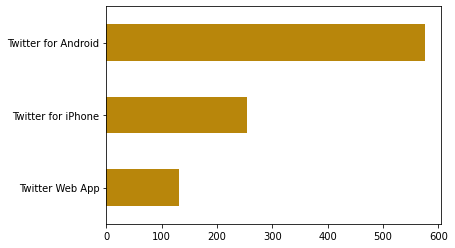

In [18]:
sources_sorted = sourceDF.sort_values('source')
ax = sources_sorted.source.plot(kind='barh',color='#B8860B')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Análise temporal**

In [19]:
from datetime import datetime

In [20]:
data = tweets_df.copy()
print(data['Date'][0])

2020-10-02 13:34:25


In [21]:
# Converte a data para apenas dia/mês e ano
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.date())
print(data['Date'][0])

2020-10-02


In [22]:
#Quantidade de Tweets por dia
QtdeDiaria = data['Date'].value_counts() 
QtdeDiaria

2020-09-26    945
2020-09-27     41
2020-10-03     12
2020-10-01      1
2020-10-02      1
Name: Date, dtype: int64

**Análise de Polaridade**

In [23]:
# !pip install googletrans
# !pip install unidecode

In [24]:
from googletrans import Translator
from unidecode import unidecode

In [25]:
#Calcula a polaridade do texto traduzido

analysis = None
polarities = []

for tweet in tweets_df['Tweets']: 
    #Texto do Tweet
    textPT = unidecode(tweet)
    
    #Traduz para o Inglês
    textEN = Translator().translate(textPT)
    
    analysis = tb(textEN.text)    
    polarity = analysis.sentiment.polarity #analisa a polaridade  
    polarities.append(polarity)

print('Vetor de polaridade:',polarities)

Vetor de polaridade: [0.0, -0.2, 0.075, 0.0, 0.25, -0.053693181818181834, 0.825, 0.0, -0.16666666666666666, 0.0, 0.140625, 0.140625, 0.140625, 0.140625, 0.140625, -0.75, 0.5, 0.18333333333333335, 0.0, 0.375, -0.3, -0.3666666666666667, 0.5, 0.5, 0.5, 0.0, 0.5, 0.075, 0.5, 0.5, 0.5, 0.0, 0.0, 0.16666666666666666, 0.10606060606060606, 0.0, 0.0, 0.16666666666666666, 0.0, 0.3181818181818182, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, -0.75, 0.027083333333333327, 0.0, 0.16666666666666666, 0.05, 0.0, 0.0, 0.0, 0.4666666666666666, 0.0, 0.0, -0.05, -0.49375, 0.16666666666666666, 0.16666666666666666, 0.3571428571428571, 0.8, 0.0, 0.75, -0.18375000000000002, 0.0, 0.16666666666666666, 0.5, 0.5, 0.16666666666666666, 0.1, 0.5, 0.5, 0.5, 0.0, 0.0, 0.4, 0.16666666666666666, 0.5, 0.5, 0.425, -0.05, 0.5, 0.5, -0.12083333333333333, -0.13499999999999995, 0.0, 0.10000000000000002, 0.5, 0.5, -0.05714285714285716, 0.16666666666666666, 0.16666666666666666, 0.05, 0.16666666666666666, -0.12083333333333333, 0.275, 0.0, 

**Análise de sentimentos**

In [26]:
print('Para a(s) palavra(s):"%s"' % keyword)
print('A MÉDIA DE SENTIMENTO É: ' + str(np.mean(polarities)))

Para a(s) palavra(s):"home office  OR  #homeoffice"
A MÉDIA DE SENTIMENTO É: 0.12421027020288739


In [27]:
positive = 0
negative = 0
neutral = 0

for polarity in polarities:
    if polarity > 0:
        positive = positive+1
    elif polarity < 0:
        negative = negative+1
    else:
        neutral = neutral+1
        
print("Tweets Positivos: %s" % positive)
print("Tweets Negativos: %s" % negative)
print("Tweets Neutros: %s" % neutral)

# Calcula percentual
pos_pct=positive*100/len(polarities)
neg_pct=negative*100/len(polarities)
neu_pct=neutral*100/len(polarities)

Tweets Positivos: 690
Tweets Negativos: 110
Tweets Neutros: 200


In [28]:
# Define variáveis
sentiments = ['Positivos', 'Negativos','Neutros']
percents = [pos_pct, neg_pct, neu_pct]

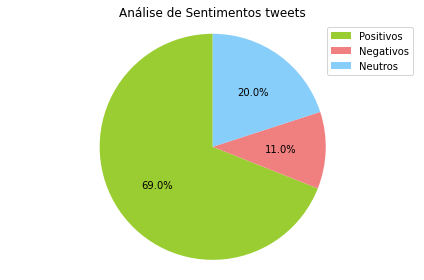

In [29]:
# plota o gráfico de análise

colors = ['yellowgreen', 'lightcoral', 'lightskyblue'] #Personalizar as cores

plt.pie(percents,colors=colors , autopct='%1.1f%%', startangle=90)
plt.legend(sentiments, loc="best")
plt.title("Análise de Sentimentos tweets")
plt.axis('equal')
plt.tight_layout()
plt.show()                

**Mapa dos tweets**

In [30]:
from geopy.geocoders import Nominatim
import folium
from folium import plugins

In [31]:
geolocator = Nominatim(user_agent="TwitterSentimentAnalysis")

#Lista para armazenar a latitude e a longitude
latitude = []
longitude = []

for user_location in tweets_df['User Location']:
    try:
        location = geolocator.geocode(user_location) 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        continue

In [32]:
coordenadas = np.column_stack((latitude, longitude))

mapa = folium.Map(zoom_start=3)
mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('Mapa_Calor_en.html')
mapa

**Nuvem de Palavras**

In [33]:
import re
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter('ignore')

In [34]:
words = ' '.join(tweets_df['Tweets'])
words

'Adesão ao naturismo para home office no Rio 🔥: não confirmo nem nego. mais alguém aí de home office sentindo falta do ar condicionado da firma?   Que calor dos 🔥🔥🔥 Bela notícia: home office no serviço público gerou economia de R$ 1 bilhão em 5 meses, no governo federal. Triste é pensar que gastaremos o dobro disso com políticos com o Fundo Eleitoral... mesmo com eles fazendo campanha de casa. https://t.co/LcewNrUksh Serasse terei que trabalhar de biquíni hoje no home office? Se Deus quiser eu fico home office pra sempre 🤞👐 @felippe_brum a gente ta de home office KKKKKK eu sou novo na empresa, então tivemos bem pouco contato tão lindo vê-la trabalhando em home office, tenho taaaaaaanto orgulho home office só assim com esse calor https://t.co/cuCslq1miK @mylimac NOSSA AMIGA, SIMMMMM! A última que vi foi de uma ex gerente escrevendo assim: “dicas de como melhorar o seu home office capenga” - a vai tomar no cu né @poxa_liin Minha vida antes da pandemia. O home office tá salvando PRODUTO M

In [35]:
# Limpeza dos dados
words = re.sub(r'“', '"', words)
words = re.sub(r'”', '"', words) # remove characteres
words = re.sub(r'\$\w*', '', words) # remove $
words = re.sub(r'@\S+', '', words) # remove mentions ou menções
words = re.sub(r'#\S+', '', words) # remove hashtags
words = re.sub(r'https?:\/\/.*[\r\n]*', '', words) # remove hyperlinks
words = re.sub('[0-9]+', '', words) #remove números
words

'Adesão ao naturismo para home office no Rio 🔥: não confirmo nem nego. mais alguém aí de home office sentindo falta do ar condicionado da firma?   Que calor dos 🔥🔥🔥 Bela notícia: home office no serviço público gerou economia de R  bilhão em  meses, no governo federal. Triste é pensar que gastaremos o dobro disso com políticos com o Fundo Eleitoral... mesmo com eles fazendo campanha de casa. '

In [36]:
words_clean = " ".join([word for word in words.split()
                            if 'https' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])

In [37]:
words_clean = " ".join([word for word in words.split()
                            if word != 'RT'
                            ])

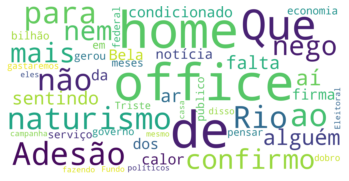

In [38]:
wc = WordCloud(min_font_size=10,max_font_size=300, 
               background_color='white', mode="RGB", width=2000, 
               height=1000, random_state=42, 
               normalize_plurals= True).generate(words_clean)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()



---



**Referências:**    

* http://docs.tweepy.org/en/v3.5.0/api.html    
* https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json
* https://textblob.readthedocs.io/en/dev/#    
* https://pypi.org/project/geopy/   
* https://python-visualization.github.io/folium/  
* https://pypi.org/project/wordcloud/



In [40]:
# Author: Priscilla Bomfim (@priscillapreks)
# Data: 03.10.2020